In [2]:
!pip install quantstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 14.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uni

In [38]:
%matplotlib inline
import quantstats as qs
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
from scipy.stats import gmean
import yfinance as yf
from pandas.tseries.offsets import BDay

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# extend pandas functionality with metrics, etc.
qs.extend_pandas()

In [6]:
indice_list = ['IPSA Index', 'S5TELS Index']

In [9]:
def load_data():
    
    #read data
    raw_data = pd.read_csv("/content/drive/MyDrive/IAQF/fundamentals.csv", low_memory = False);
    
    #get the keys (indices)
    indices = raw_data.keys()
    
    #rename the columns to features
    raw_data.rename(columns = raw_data.iloc[0], inplace = True)
    
    #drop columns from data values
    raw_data.drop([0], inplace = True)
    
    #convert dates column to date format
    raw_data["Dates"] = pd.to_datetime(raw_data['Dates'], format = "%d-%m-%Y")
    #set dates as index
    raw_data.set_index("Dates", inplace = True)
    
    #extract list of indices
    indices = indices.to_list()
    indices = indices[1:]
    
    final_indices = []
    
    for i in range(len(indices)):
        if i%23 == 0:
            final_indices.append(indices[i])
     
    columns = []
    for i in raw_data.keys():
        columns.append(i)
    
    #make the columns unique
    temp_columns = columns.copy()
    for i in range(len(columns)):
        temp_columns[i] = temp_columns[i] + " "+ final_indices[int(i/23)]
    
    #drop first row
    raw_data.drop("01-01-2010", inplace = True)
    
    #rename columns
    raw_data.columns = temp_columns
    
    #change data type to float
    raw_data = raw_data.astype(float)
                                       
    #get list of features
    final_columns = [];
    [final_columns.append(x) for x in columns if x not in final_columns];
    
    #make a 3d dataframe
    final_dict = {}
    for i in range(len(raw_data.keys())):
        final_dict[final_indices[int(i/23)], final_columns[i%23]] = raw_data[raw_data.keys()[i]]
        
    final_raw_data = pd.DataFrame(final_dict)
    
    #get all the indices where all data is present
    temp_dict = {}
    for outer_key in final_indices:
        if len(final_raw_data[outer_key].dropna(axis = 1).keys()) == 23:
            for inner_key in final_raw_data[outer_key].keys():
                temp_dict[outer_key, inner_key] = final_raw_data[outer_key][inner_key]
    
    final_df = pd.DataFrame(temp_dict)
    
    return final_df

In [10]:
# Load price data for the pair
data = load_data()
pair_name = indice_list[0] + " - " + indice_list[1]
price_col = 'PX_LAST'
px_data = data[indice_list].xs(price_col, axis=1, level=1, drop_level=True)
px_data

,IPSA Index,S5TELS Index
Dates,,
2010-01-04,3620.70,116.42
2010-01-05,3624.10,116.64
2010-01-06,3639.96,113.17
2010-01-07,3681.06,112.21
2010-01-08,3726.50,111.70
...,...,...
2023-02-01,5308.17,184.49
2023-02-02,5313.52,196.92
2023-02-03,5314.29,192.55


In [11]:
# Generating random weights for testing
np.random.seed(0)
n = 2
rand_nos = np.random.rand(len(px_data.index), n)
pf_weights = (rand_nos.transpose() / rand_nos.sum(axis=1)).transpose()
pf_weights = pd.DataFrame(pf_weights, index=px_data.index, columns=px_data.columns)
# Replace with model output weights by populating 'pf_weights'. Keep it as a DataFrame.

In [12]:
pf_weights

,IPSA Index,S5TELS Index
Dates,,
2010-01-04,0.434187,0.565813
2010-01-05,0.525217,0.474783
2010-01-06,0.396106,0.603894
2010-01-07,0.329171,0.670829
2010-01-08,0.715359,0.284641
...,...,...
2023-02-01,0.887726,0.112274
2023-02-02,0.121112,0.878888
2023-02-03,0.680197,0.319803


In [13]:
# Computing asset returns and portfolio returns. 
# Assuming execution at previous day close price so that weight at day T earns return from Day T-1 close to day T close.
# Can be modified for execution at open price.
asset_returns = px_data.pct_change()
asset_returns = asset_returns.tail(-1)
pf_weights = pf_weights.tail(-1)
pf_returns = (asset_returns * pf_weights).sum(axis=1)
pf_returns

Dates
2010-01-05    0.001390
2010-01-06   -0.016232
2010-01-07   -0.001974
2010-01-08    0.007537
2010-01-11    0.002699
                ...   
2023-02-01   -0.000861
2023-02-02    0.059337
2023-02-03   -0.006998
2023-02-06   -0.007678
2023-02-07    0.015845
Length: 3416, dtype: float64

In [14]:
start_date = pf_returns.index.min().date()
end_date = pf_returns.index.max().date()

In [15]:
# adding benchmark
benchmark_ticker = 'SPY'
benchmark = pd.DataFrame(qs.utils.download_returns('SPY'))
benchmark.index = benchmark.index.tz_convert(None)
benchmark.index = benchmark.index.normalize()
benchmark = benchmark.loc[(benchmark.index.date >= start_date) & (benchmark.index.date <= end_date), :]
benchmark = benchmark.reindex(pf_returns.index, fill_value=0.0)
benchmark

,Close
Dates,
2010-01-05,0.002647
2010-01-06,0.000704
2010-01-07,0.004221
2010-01-08,0.003328
2010-01-11,0.001397
...,...
2023-02-01,0.010628
2023-02-02,0.014557
2023-02-03,-0.010629


In [16]:
# adding risk free rate
# 90 day t-bill rate
rf_ticker = 'SPY'
rf = pd.DataFrame(yf.download('^IRX', start=start_date, end=end_date + BDay(1)))
rf = rf['Close']
rf = rf.reindex(pf_returns.index, method='ffill')
rf = rf / 100
rf

[*********************100%***********************]  1 of 1 completed


Dates
2010-01-05    0.00060
2010-01-06    0.00045
2010-01-07    0.00045
2010-01-08    0.00040
2010-01-11    0.00025
               ...   
2023-02-01    0.04520
2023-02-02    0.04510
2023-02-03    0.04523
2023-02-06    0.04533
2023-02-07    0.04570
Name: Close, Length: 3416, dtype: float64

In [17]:
type(pf_returns)

pandas.core.series.Series

In [18]:
# deannualizing risk free rate
rf = np.power(1 + rf, 1. / 252) - 1.
rf

Dates
2010-01-05    2.380241e-06
2010-01-06    1.785314e-06
2010-01-07    1.785314e-06
2010-01-08    1.586985e-06
2010-01-11    9.919400e-07
                  ...     
2023-02-01    1.754450e-04
2023-02-02    1.750652e-04
2023-02-03    1.755589e-04
2023-02-06    1.759386e-04
2023-02-07    1.773432e-04
Name: Close, Length: 3416, dtype: float64

In [19]:
# computing excess returns
pf_excess_returns = pf_returns - rf
benchmark_excess_returns = pd.DataFrame(benchmark['Close'] - rf, columns=benchmark.columns, index=benchmark.index)

In [20]:
type(pf_excess_returns)

pandas.core.series.Series

In [21]:
benchmark_excess_returns

,Close
Dates,
2010-01-05,0.002645
2010-01-06,0.000702
2010-01-07,0.004219
2010-01-08,0.003326
2010-01-11,0.001396
...,...
2023-02-01,0.010452
2023-02-02,0.014382
2023-02-03,-0.010805


In [27]:
# Creating performance and risk summary report
# Create Outputs folder in directory and download the html report
qs.reports.html(pf_excess_returns, benchmark_excess_returns, rf=0.0, output=True, match_dates=True, 
                download_filename='/content/{0}.html'.format(pair_name))

In [24]:
# Hypothesis testing for excess returns (or equivalently sharpe) statistically significantly greater than 0
tstat1, pval1 = ttest_1samp(pf_excess_returns, 0)
tstat2, pval2 = ttest_1samp(benchmark_excess_returns['Close'], 0)
res = pd.DataFrame({'T-Statistic': [tstat1, tstat2], 'P-Value': [pval1, pval2]}, index=[pair_name, 'Benchmark'])
res.to_csv('/content/{0}.csv'.format(pair_name))
res

,T-Statistic,P-Value
IPSA Index - S5TELS Index,0.953172,0.340570
Benchmark,2.613634,0.008998


In [66]:
def bootstrap(ser):
    ser.dropna(inplace=True)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    # ave = np.average(arr) #arithmetic mean
    ave = gmean(1+arr)-1 #geometric mean

    print("average return %f" %ave)

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    # mb = xb.mean(axis=0) #arithmetic mean
    mb = gmean(1+xb, axis=0)-1 #geometric mean

    #sorts the 50000 averages
    mb.sort()
    print(mb.min(), mb.max())
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5])) 
    threshold = np.percentile(mb, [percentile])[0]


    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value greater than zero (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break
        
    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)

    print("p_value:")
    print(p)


    
    #histogram
    sr = pd.Series(mb)
    desc = sr.describe()
    count = desc[0]
    std = desc[2]
    minim = desc[3]
    maxim = desc[7]
    R = maxim-minim
    n = count
    s = std
    bins = int(round(R*(n**(1/3))/(3.49*std),0))
    fig = sr.hist(bins=bins)
   # plt.show()
    

    #about the histogram
    #https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram
    #R(n^(1/3))/(3.49σ)
    #R is the range of data (in your case R = 3-(-3)= 6),
    #n is the number of samples,
    #σ is your standard deviation.


average return 0.000112
-0.0006526379676029537 0.0006143336408919176
[-0.00033911  0.0003314 ]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.2542


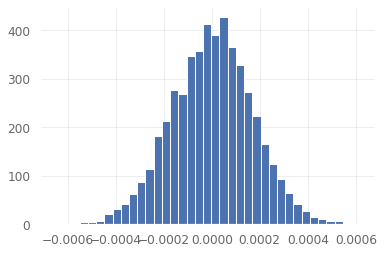

In [67]:
bootstrap(pf_excess_returns)

In [61]:
(gmean(1+pf_excess_returns)-1)

0.00011176498269072077